# Haldane Model

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

Nx = 20           # number of unit cells along a1
Ny = 20           # number of unit cells along a2
N_cells = Nx * Ny
dim = 2 * N_cells  # two sites per unit cell

t1 = 2.0          # NN
t2 = 0.5          # NNN
phi = np.pi / 2   # phase for NNN hopping
M = 1.0             # on-site potential

tol = 0.10        # tolerance

# Lattice Vectors and Basis
a1 = np.array([np.sqrt(3)/2, 3/2])
a2 = np.array([-np.sqrt(3)/2, 3/2])
r_A_basis = np.array([0, 0])
r_B_basis = np.array([0, 1])


positions = {}    # dictionary: site index -> (x, y)
sublattice = {}   # dictionary: site index -> 'A' or 'B'
cell_index = 0

for i in range(Nx):
    for j in range(Ny):
        R = i * a1 + j * a2  # Bravais lattice vector for unit cell (i,j)
        # A site:
        idx_A = 2 * cell_index
        pos_A = R + r_A_basis
        positions[idx_A] = pos_A
        sublattice[idx_A] = 'A'
        # B site:
        idx_B = 2 * cell_index + 1
        pos_B = R + r_B_basis
        positions[idx_B] = pos_B
        sublattice[idx_B] = 'B'
        cell_index += 1

# cell index = i Ny + j hence i = cell_index // Ny  and j = cell_index mod Ny

# Hamiltonian
H = np.zeros((dim, dim), dtype=complex)

# On-site potentials:
for i in range(dim):
    H[i, i] += M if sublattice[i] == 'A' else -M

# Pre-calculate expected distances:
NN_distance = 1.0
NNN_distance = np.sqrt(3)

# Add hopping terms (only for i < j for efficiency; Hermitian conjugate added)
for i in range(dim):
    for j in range(i+1, dim):
        rij = positions[i] - positions[j]
        dist = np.linalg.norm(rij)
        # NN hopping:
        if abs(dist - NN_distance) < tol and (sublattice[i] != sublattice[j]):
            H[i, j] += -t1
            H[j, i] += -t1
        # NNN hopping (same sublattice) with phase:
        elif abs(dist - NNN_distance) < tol and (sublattice[i] == sublattice[j]):
            common_neighbors = []
            for k in range(dim):
                if k == i or k == j:
                    continue
                if (abs(np.linalg.norm(positions[i] - positions[k]) - NN_distance) < tol and
                    abs(np.linalg.norm(positions[j] - positions[k]) - NN_distance) < tol):
                    common_neighbors.append(k)
            if len(common_neighbors) == 1:
                k = common_neighbors[0]
                v1 = positions[k] - positions[i]
                v2 = positions[j] - positions[k]
                cross_z = v1[0]*v2[1] - v1[1]*v2[0]  # 2D cross product
                nu_ij = 1 if cross_z > 0 else -1
                H[i, j] += -t2 * np.exp(1j * nu_ij * phi)
                H[j, i] += -t2 * np.exp(-1j * nu_ij * phi)

# Filter Out the Very Top and Bottom Sites
# Compute y-coordinates for all sites:
y_coords = [positions[i][1] for i in range(dim)]
y_min = min(y_coords)
y_max = max(y_coords)
tol_boundary = 1e-6  # tolerance

# List of site indices that are NOT at the extreme top or bottom:
valid_indices = [i for i in range(dim)
                 if (abs(positions[i][1] - y_min) > tol_boundary) and
                    (abs(positions[i][1] - y_max) > tol_boundary)]
print("Number of sites before filtering:", dim)
print("Number of sites after filtering:", len(valid_indices))

# Create the reduced Hamiltonian using only valid sites:
H_valid = H[np.ix_(valid_indices, valid_indices)]

# Build filtered dictionaries for positions and sublattice:
positions_valid = {new_i: positions[old_i] for new_i, old_i in enumerate(valid_indices)}
sublattice_valid = {new_i: sublattice[old_i] for new_i, old_i in enumerate(valid_indices)}

# ----- Diagonalize the Reduced Hamiltonian -----
eigenvalues_valid, eigenvectors_valid = eigh(H_valid)
nearest_indices_valid = np.argsort(np.abs(eigenvalues_valid))[:29]
nearest_eigenvalues_valid = eigenvalues_valid[nearest_indices_valid]
nearest_eigenvectors_valid = eigenvectors_valid[:, nearest_indices_valid]

print("Eigenvalues closest to zero (filtered):", nearest_eigenvalues_valid)

Number of sites before filtering: 800
Number of sites after filtering: 798
Eigenvalues closest to zero (filtered): [-0.0832402   0.0832402  -0.24924237  0.24924237 -0.4137998   0.4137998
 -0.57592017  0.57592017 -0.73457936  0.73457936  0.8887259  -0.8887259
 -1.03729791  1.03729791 -1.17925431  1.17925431 -1.3134962   1.3134962
 -1.43735681  1.43735681 -1.54133756  1.54133756 -1.61353358  1.61353358
 -1.62062361  1.62062361  1.64743436 -1.64743436  1.65109873]


##  The honeycomb lattice structure

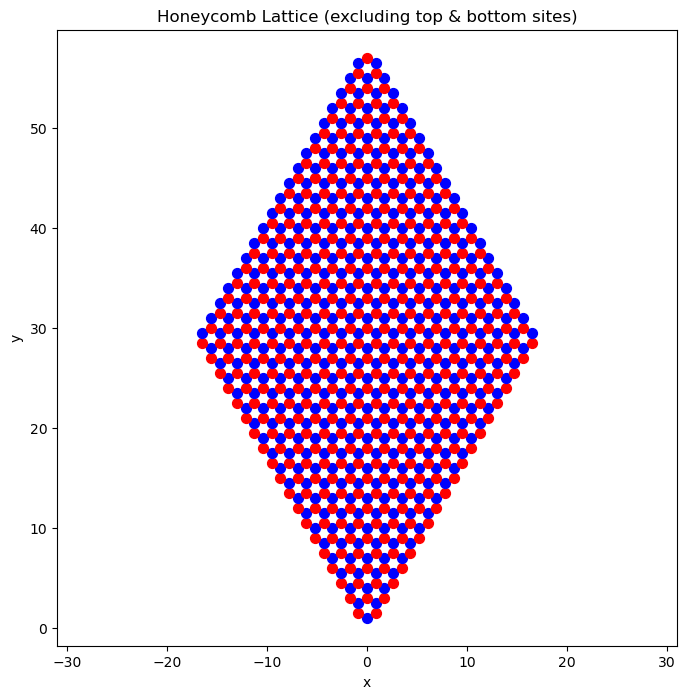

In [58]:
# ----- Plot the Filtered Honeycomb Lattice -----
plt.figure(figsize=(8, 8))
ax = plt.gca()
for i in range(len(valid_indices)):
    x, y = positions_valid[i]
    color = 'red' if sublattice_valid[i] == 'A' else 'blue'
    ax.scatter(x, y, color=color, s=50, zorder=3)

# Draw nearest-neighbor bonds using the filtered site positions:
for i in range(len(valid_indices)):
    for j in range(i+1, len(valid_indices)):
        rij = positions_valid[i] - positions_valid[j]
        dist = np.linalg.norm(rij)
        if abs(dist - NN_distance) < tol:
            x_vals = [positions_valid[i][0], positions_valid[j][0]]
            y_vals = [positions_valid[i][1], positions_valid[j][1]]
            ax.plot(x_vals, y_vals, color='gray', zorder=1)

ax.set_title("Honeycomb Lattice (excluding top & bottom sites)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.axis('equal')
plt.show()


## Eigenvalue spectrum

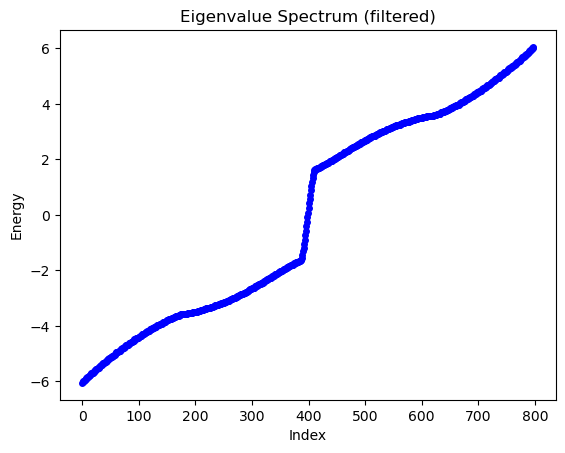

In [66]:
# ----- Plot the Eigenvalue Spectrum (Filtered) -----
plt.figure()
plt.plot(eigenvalues_valid, 'bo', markersize=4)
plt.title("Eigenvalue Spectrum (filtered)")
plt.xlabel("Index")
plt.ylabel("Energy")
plt.show()


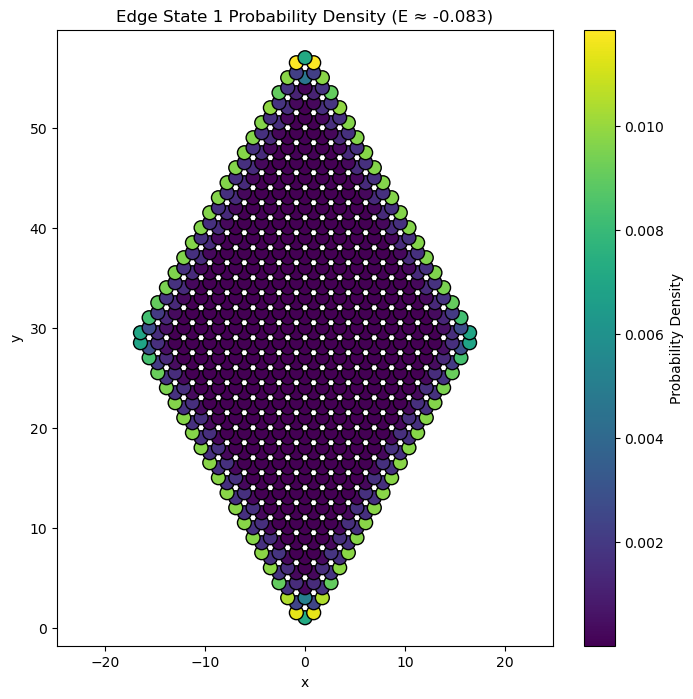

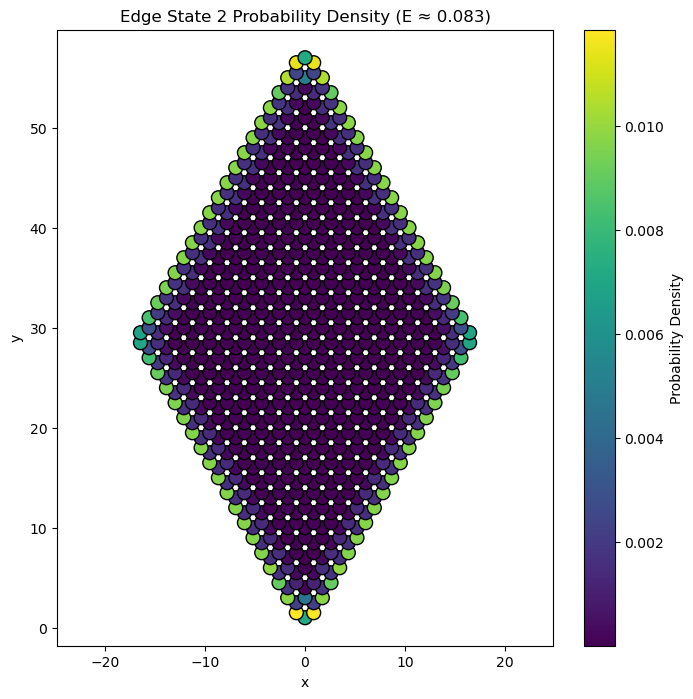

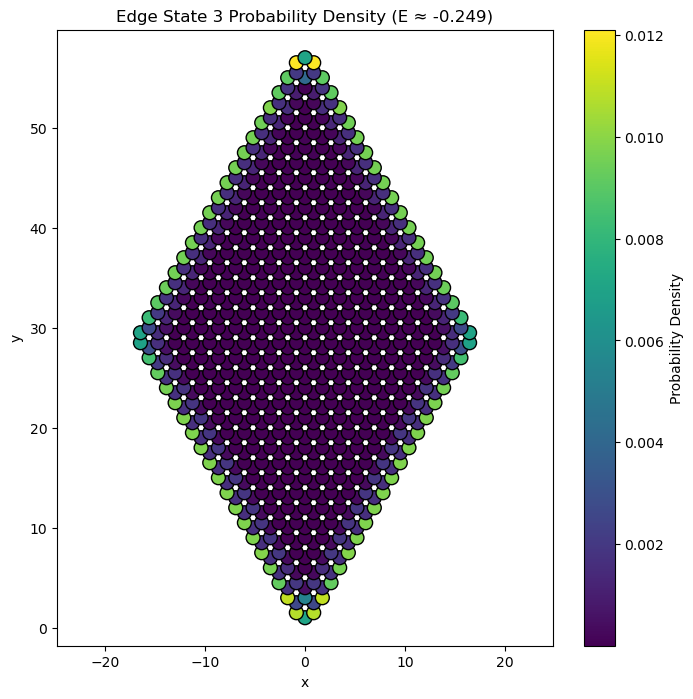

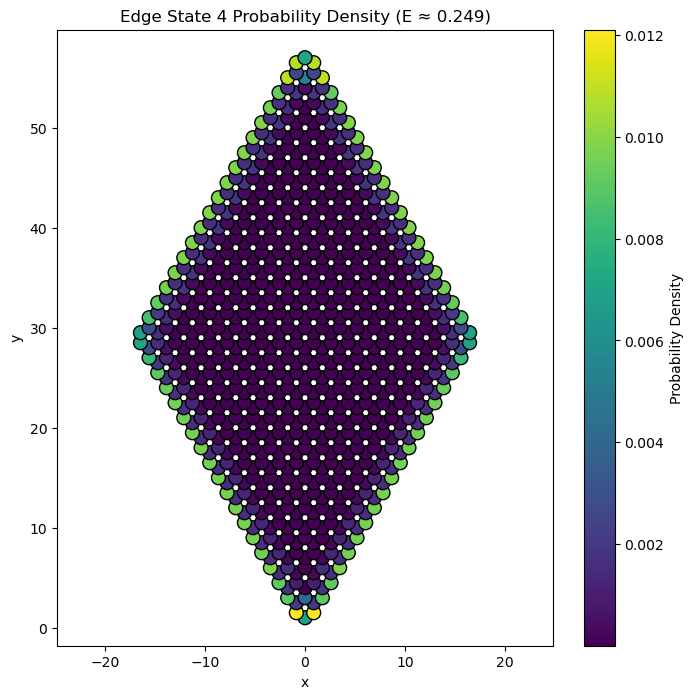

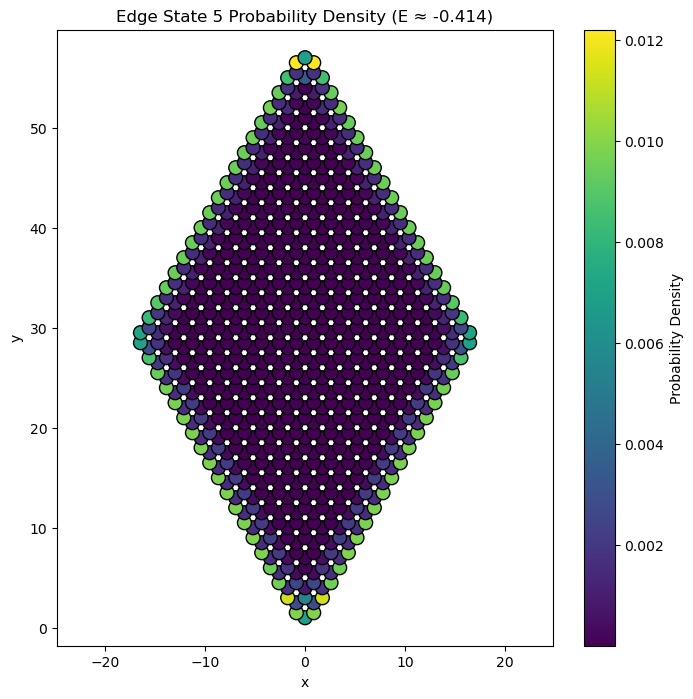

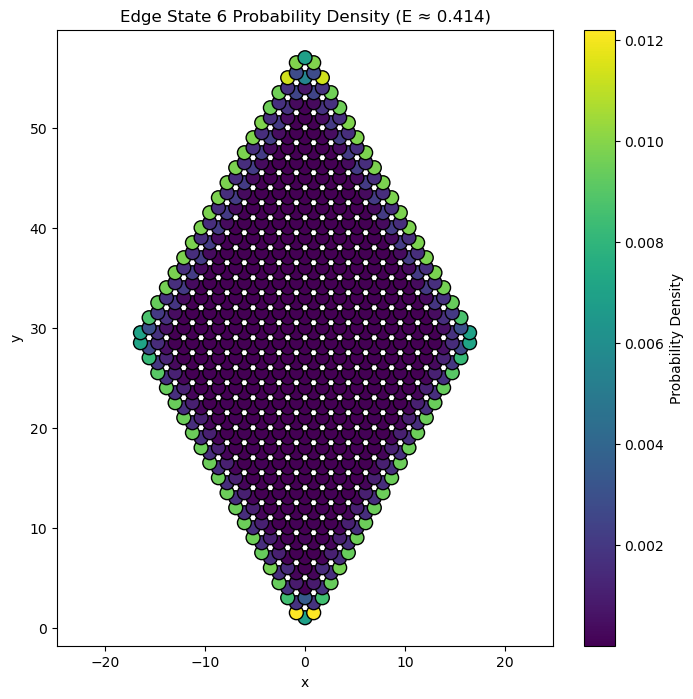

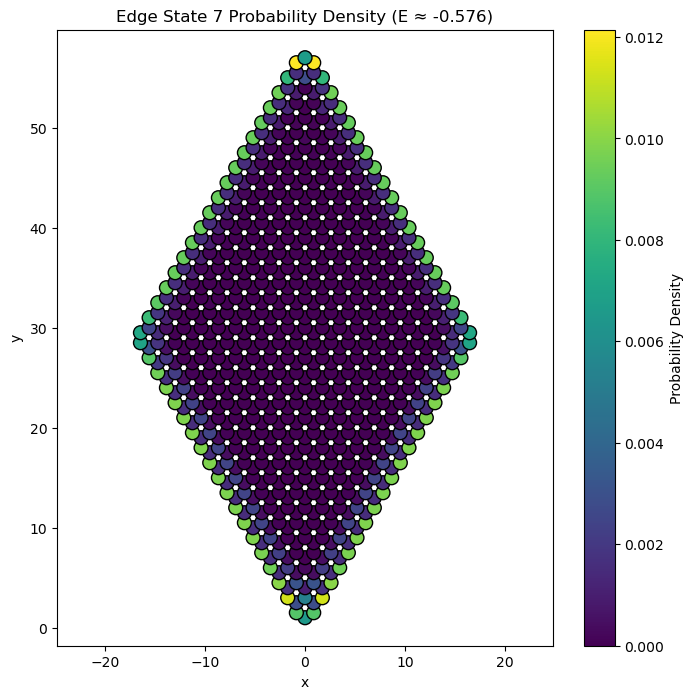

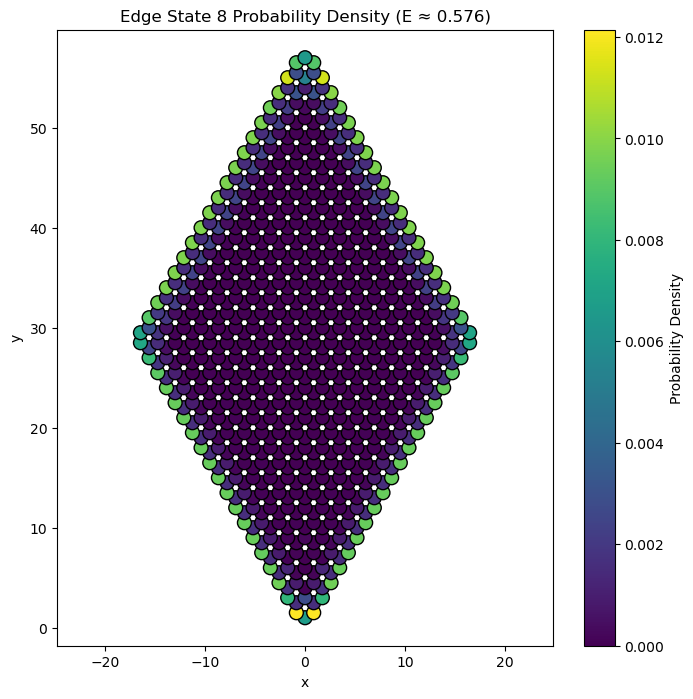

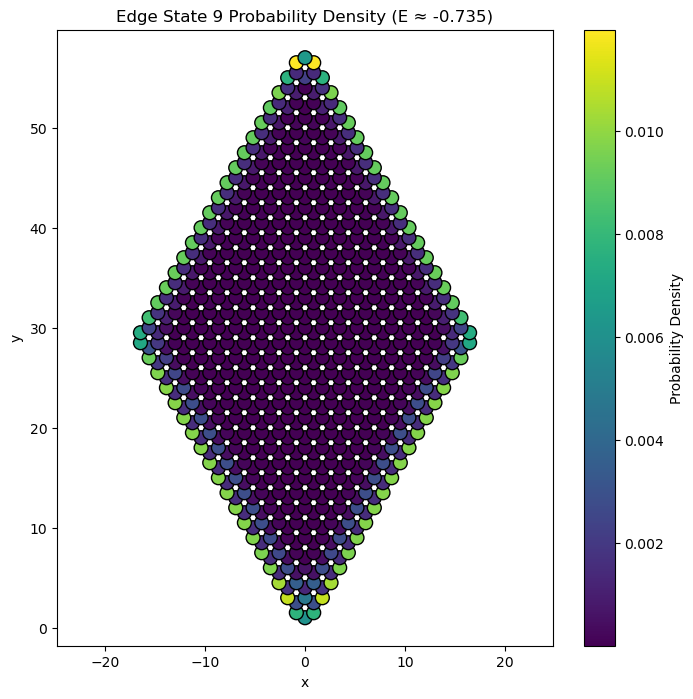

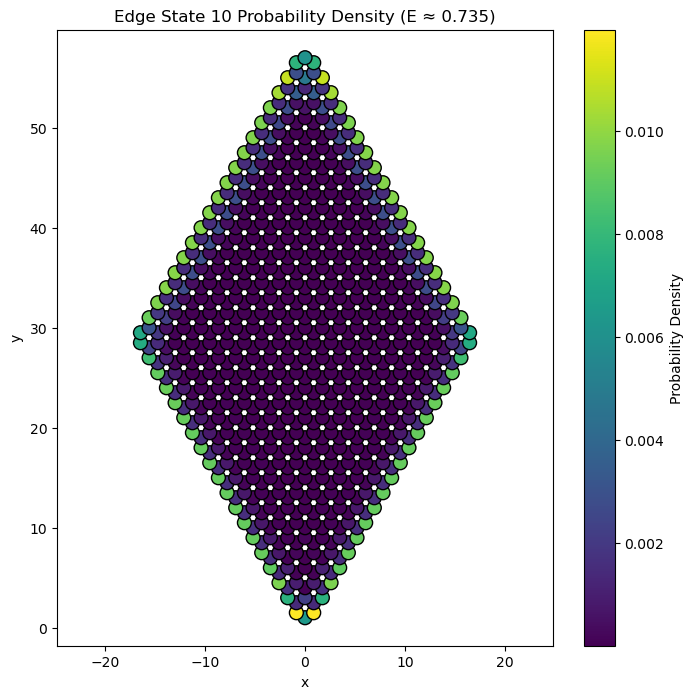

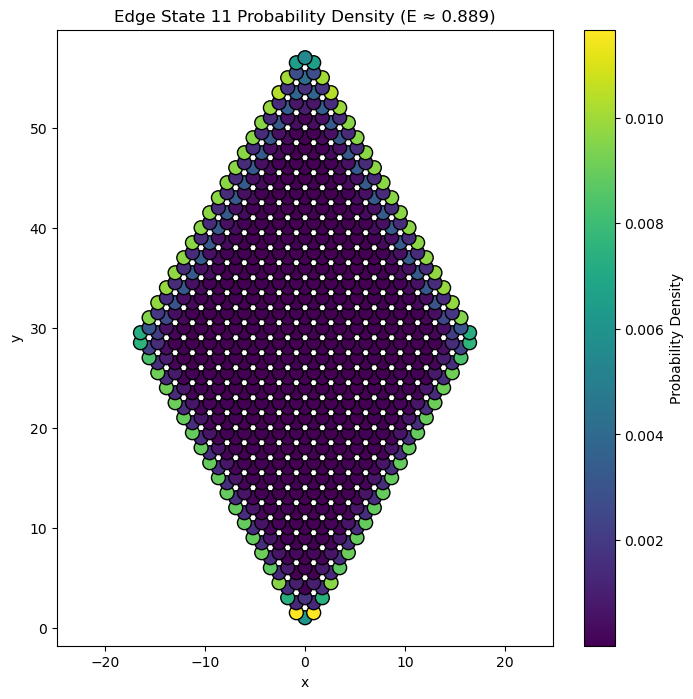

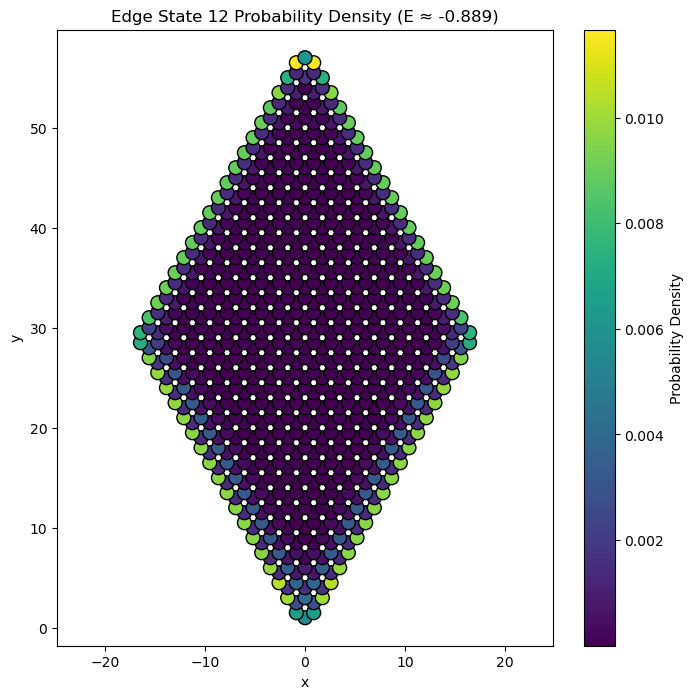

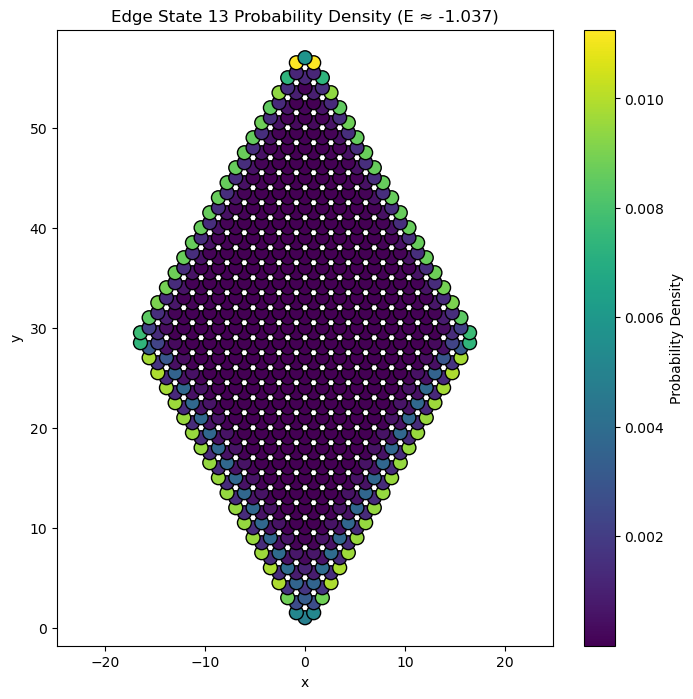

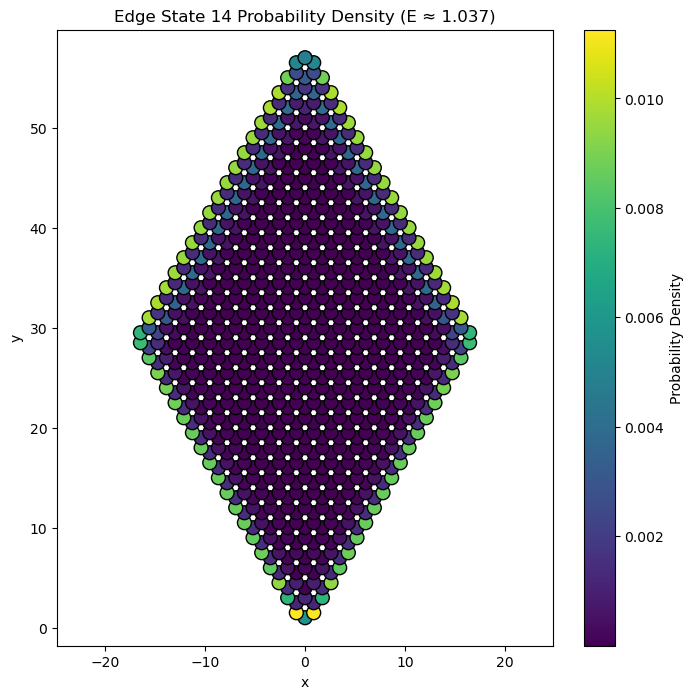

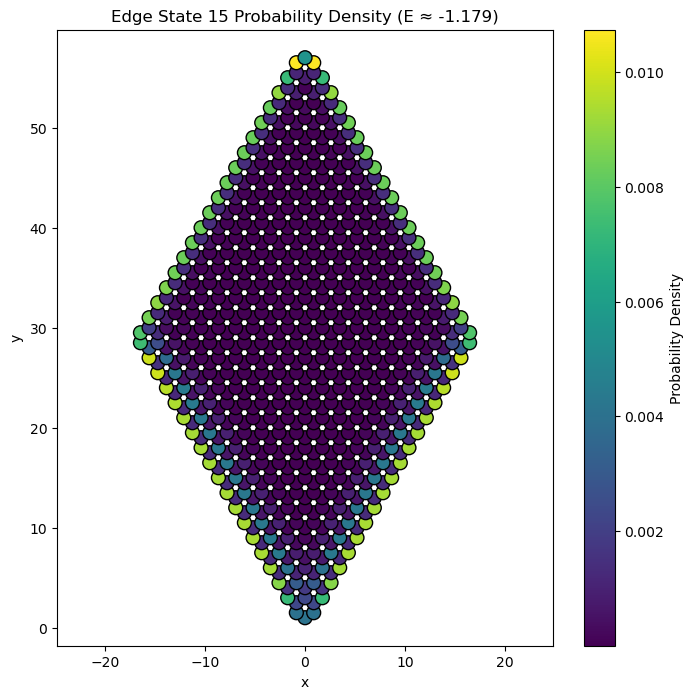

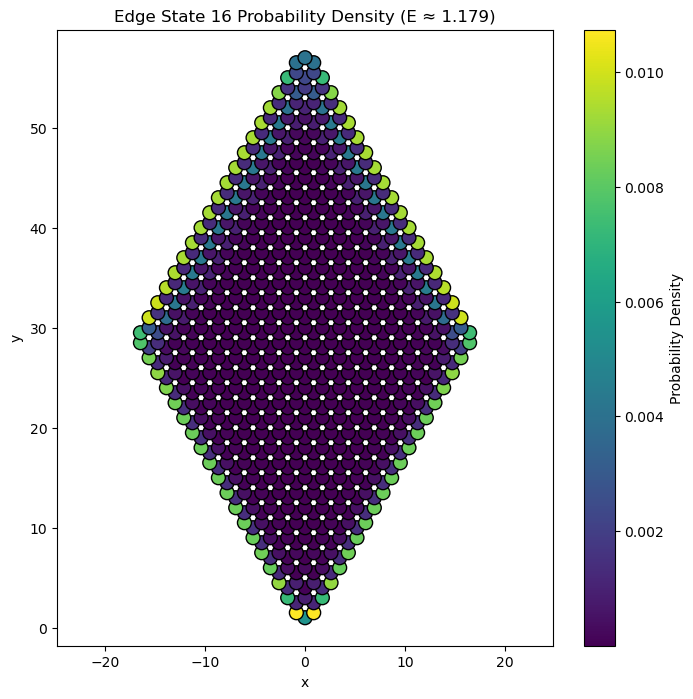

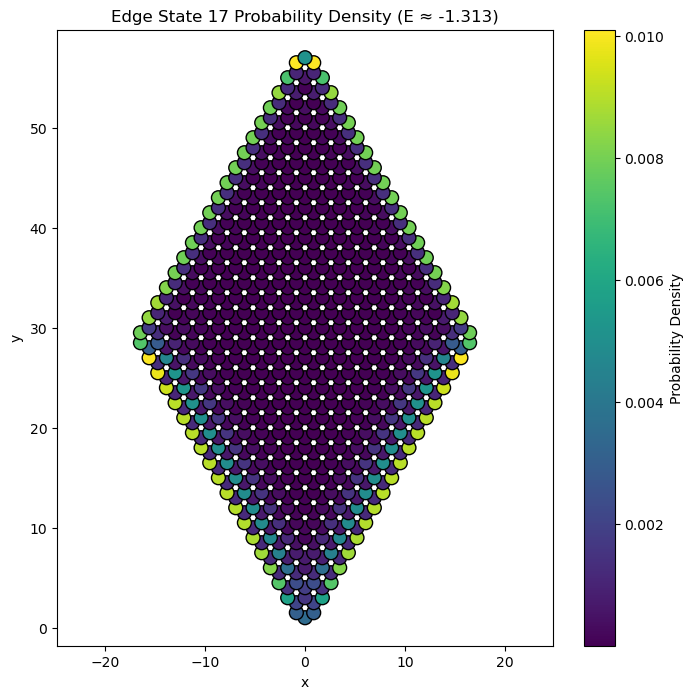

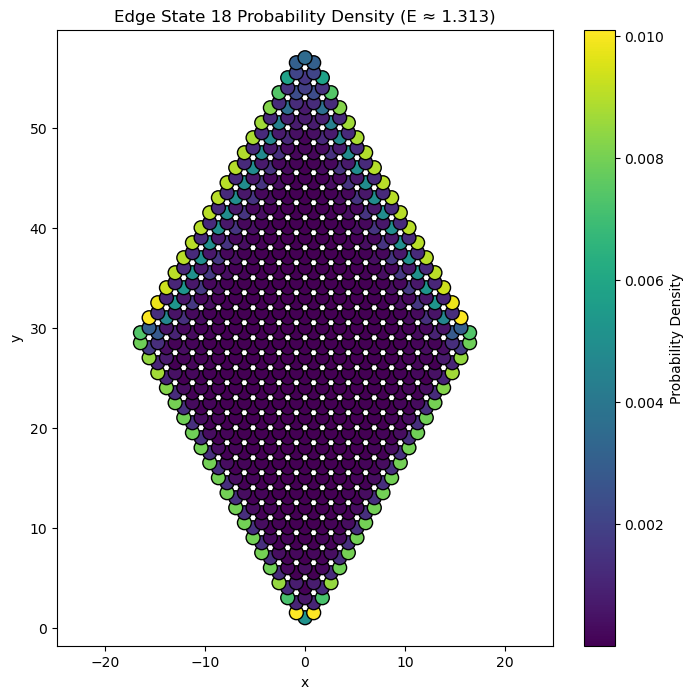

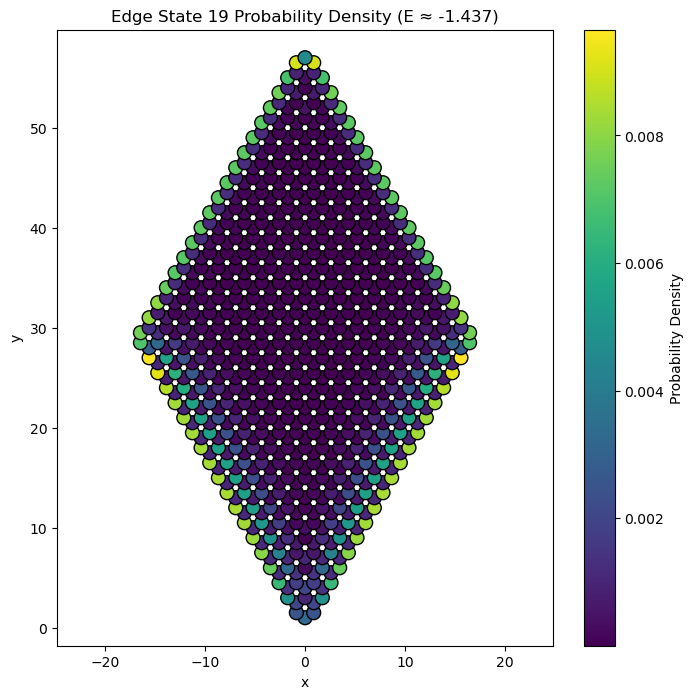

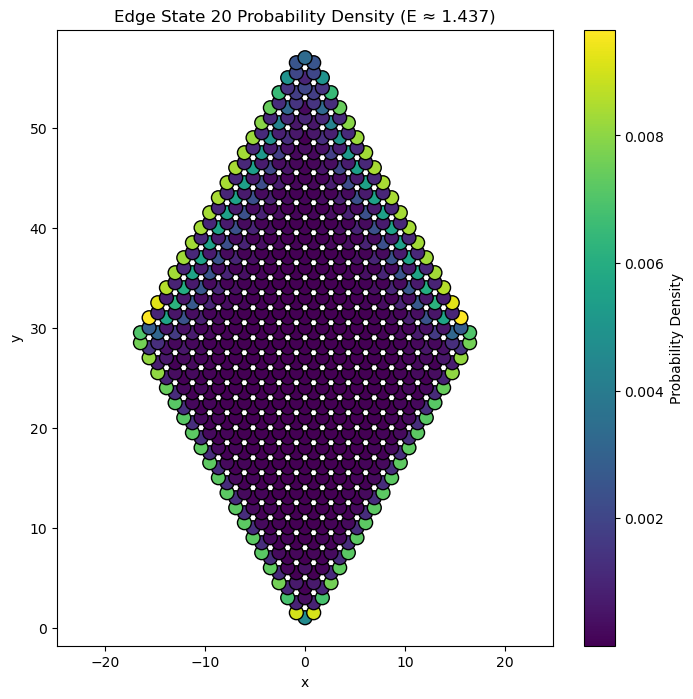

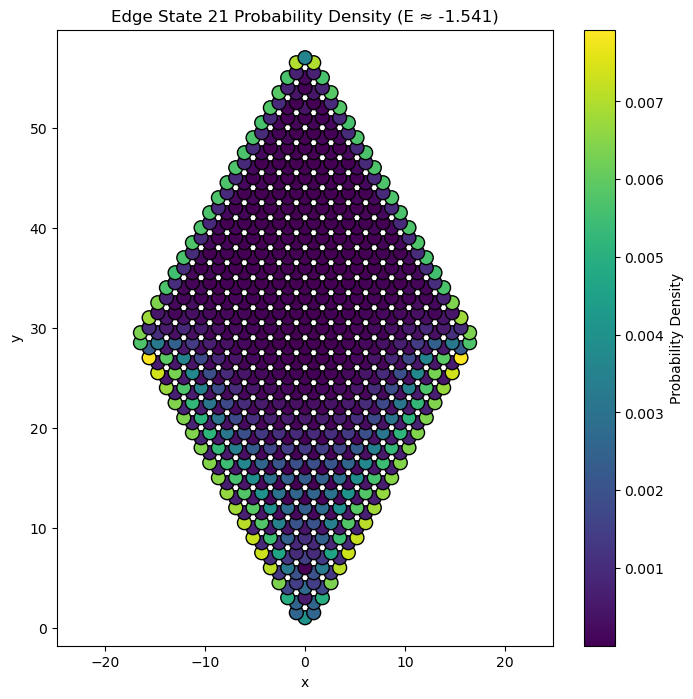

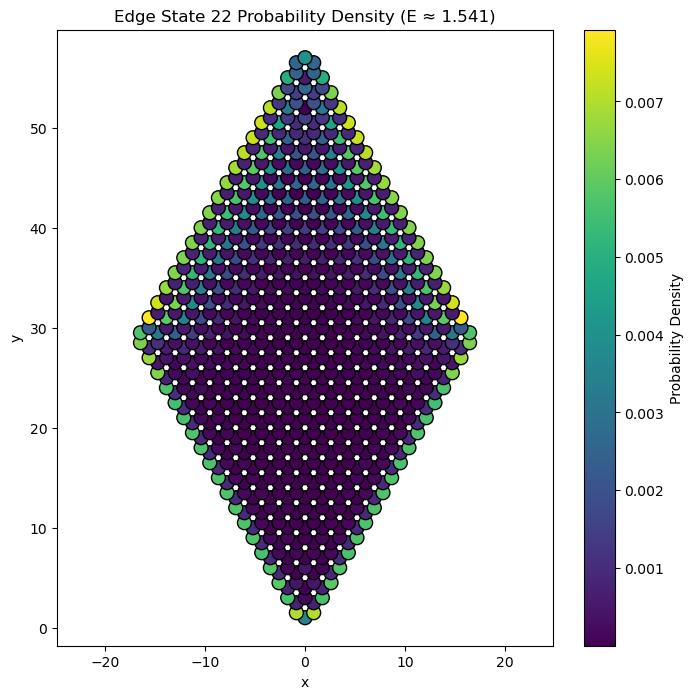

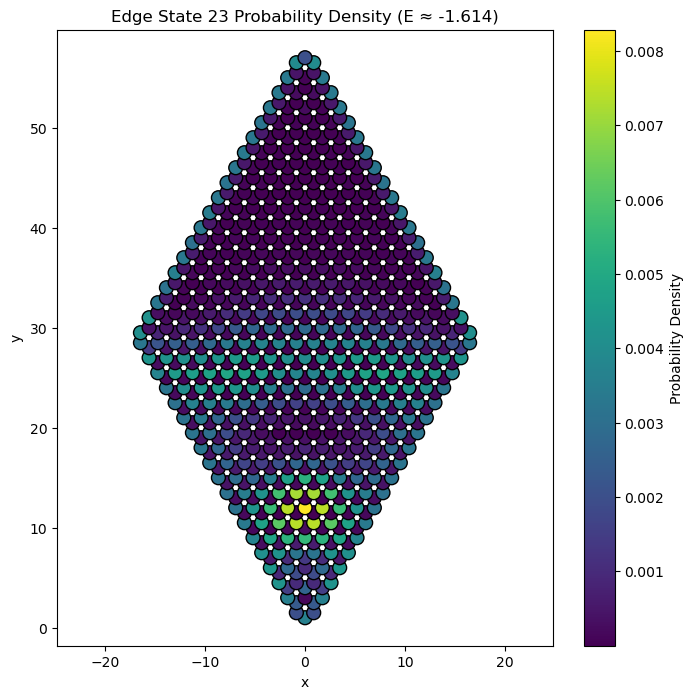

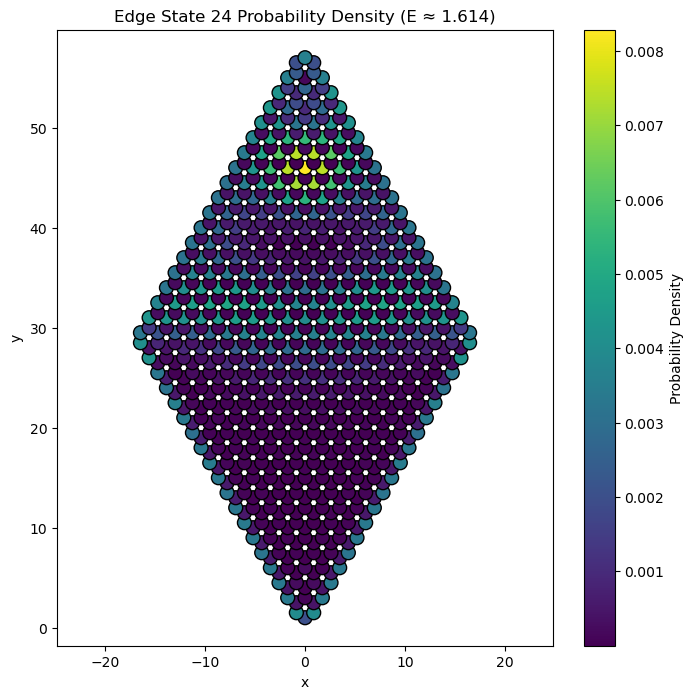

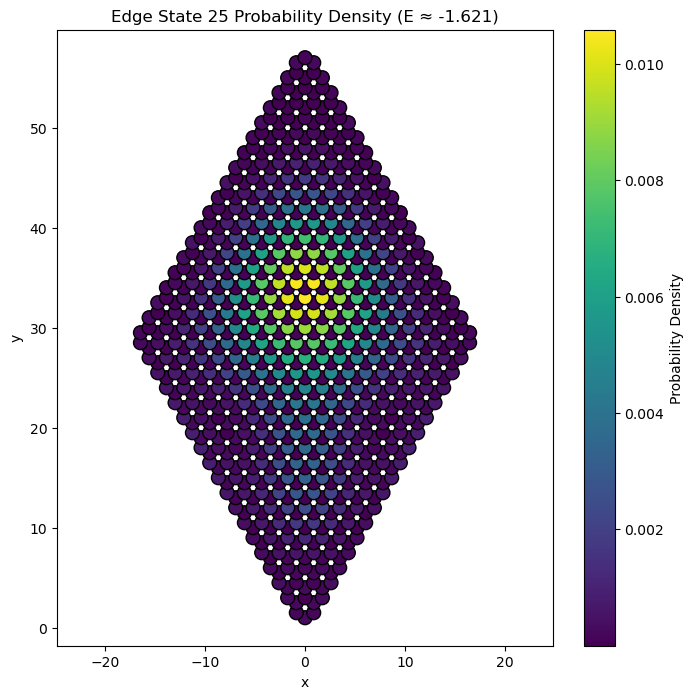

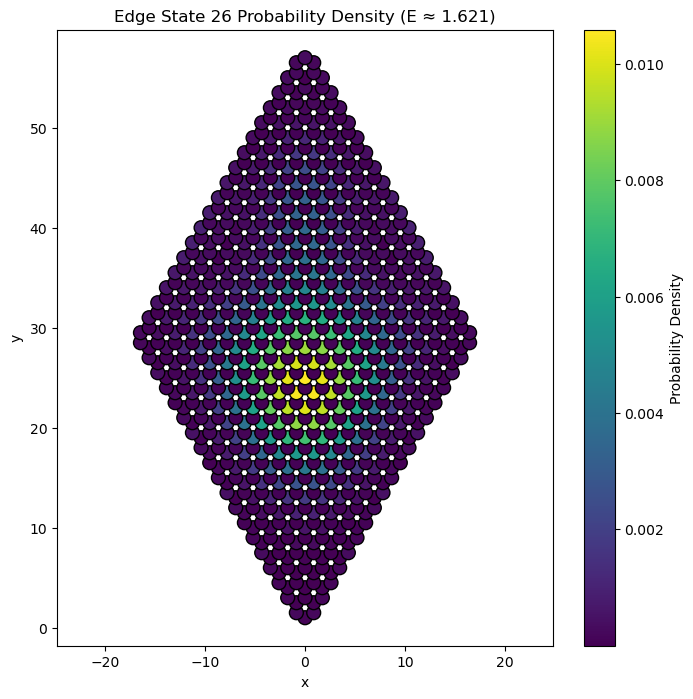

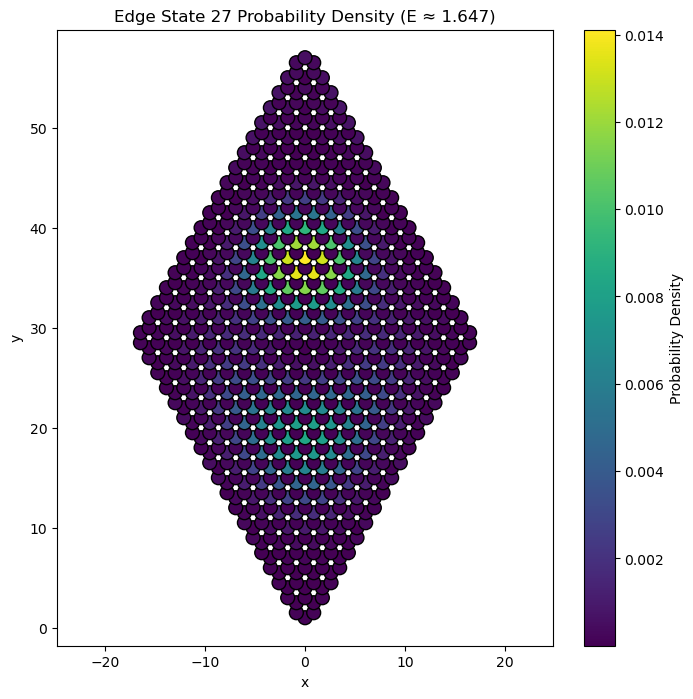

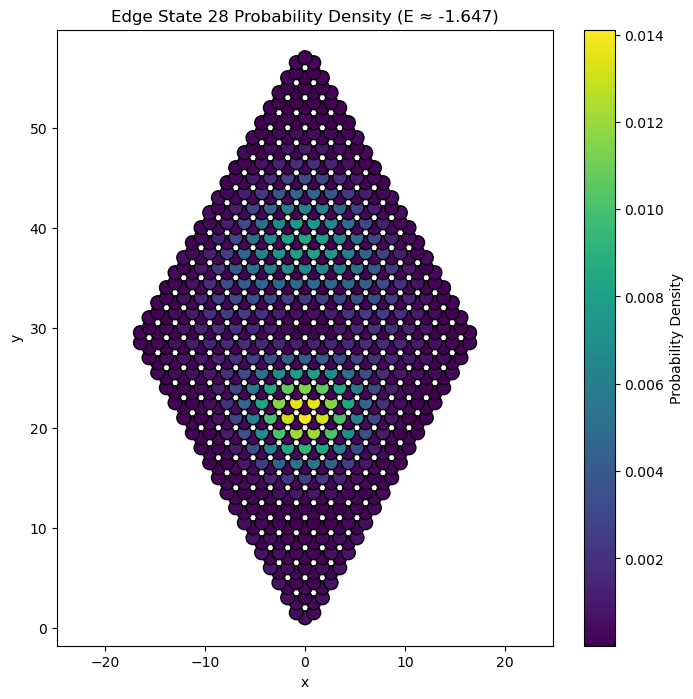

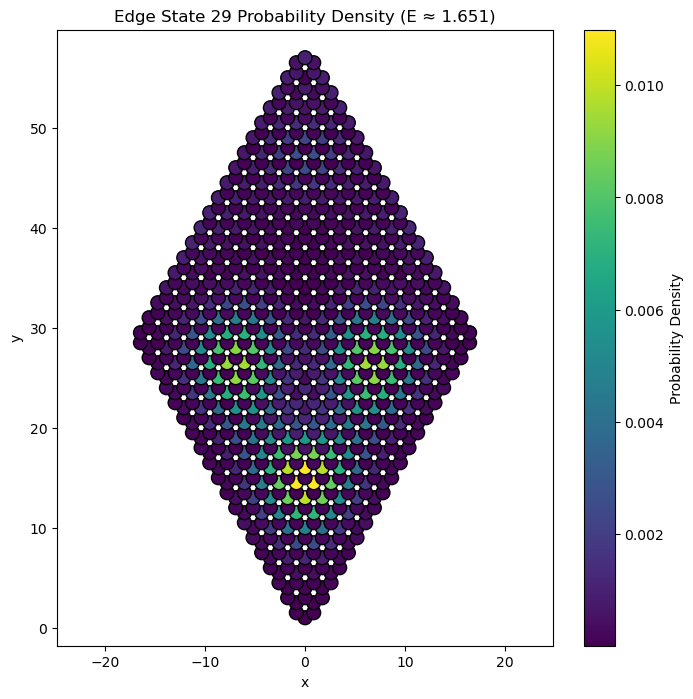

In [67]:
# ----- Plot Probability Density for Edge States -----
for state_idx in range(nearest_eigenvectors_valid.shape[1]):
    psi = nearest_eigenvectors_valid[:, state_idx]
    prob_density = np.abs(psi)**2  # |ψ|^2

    plt.figure(figsize=(8, 8))
    xs = [positions_valid[i][0] for i in range(len(valid_indices))]
    ys = [positions_valid[i][1] for i in range(len(valid_indices))]
    sc = plt.scatter(xs, ys, c=prob_density, cmap='viridis', s=100, edgecolors='k')
    plt.colorbar(sc, label='Probability Density')
    plt.title(f'Edge State {state_idx+1} Probability Density (E ≈ {nearest_eigenvalues_valid[state_idx]:.3f})')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis('equal')
    plt.show()